# cogni

In [288]:
import numpy as np
import sys
filePath = '/Users/lichan/Desktop/Postgraduates/Pychan/Utils/nup/'
sys.path.append(filePath)
from functions import relu,drelu,softmax,divi_,mini_batch_generate,sigmoid,dsigmoid,turn_2_zero,scale,tanh,dtanh
import os
filePath = '/Users/lichan/Desktop/Postgraduates/Pychan/'
sys.path.append(filePath)
from dataset import load
# from optimizers import Adam
# import load2

In [289]:
class RNN:
    def __init__(self, n_in, n_rec, n_out, tau_m=100):
        self.n_in = n_in
        self.n_rec = n_rec
        self.n_out = n_out
        self.tau_m = tau_m

        # Initialization of parameters: pi, m, xi
        self.m_in = np.random.normal(0,1/(n_in**0.5),[n_rec,n_in])
        self.xi_in = np.zeros((n_rec,n_in))
        self.pi_in = np.zeros((n_rec,n_in))
        
        self.m_rec = np.random.normal(0,1/(n_rec**0.5),[n_rec,n_rec])
        self.xi_rec = 0.01*np.random.random((n_rec,n_rec))
        self.pi_rec = np.zeros((n_rec,n_rec))
       
        self.m_out = np.random.normal(0,1/(n_rec**0.5),[n_out,n_rec])
        self.xi_out = 0.01*np.random.random((n_out,n_rec))
        self.pi_out = np.zeros((n_out,n_rec))
       
        #important intermediate variable
        #权重w的一阶矩和二阶矩
        self.mu_in = self.m_in*(1-self.pi_in)
        self.rho_in = (1-self.pi_in)*(self.xi_in + self.m_in**2)

        self.mu_rec = self.m_rec*(1-self.pi_rec)
        self.rho_rec = (1-self.pi_rec)*(self.xi_rec + self.m_rec**2)

        self.mu_out = self.m_out*(1-self.pi_out)
        self.rho_out = (1-self.pi_out)*(self.xi_out + self.m_out**2)
                
        # rmsprop 应需要9个优化器
        self.RMSp_m_in = RMS_prop()
        self.RMSp_xi_in = RMS_prop()
        self.RMSp_pi_in = RMS_prop()
        self.RMSp_m_rec = RMS_prop()
        self.RMSp_xi_rec = RMS_prop()
        self.RMSp_pi_rec = RMS_prop()
        self.RMSp_m_out = RMS_prop()
        self.RMSp_xi_out = RMS_prop()
        self.RMSp_pi_out = RMS_prop()  
        
        #adam 需要9个优化器
        self.Adam_m_in = Adam()
        self.Adam_xi_in = Adam()
        self.Adam_pi_in = Adam()
        self.Adam_m_rec = Adam()
        self.Adam_xi_rec = Adam()
        self.Adam_pi_rec = Adam()
        self.Adam_m_out = Adam()
        self.Adam_xi_out = Adam()
        self.Adam_pi_out = Adam()  

    def uniform_pi(self):
        self.pi_rec = np.random.random((self.n_rec,self.n_rec))
        self.pi_out = np.random.random((self.n_out,self.n_rec))        
    
    def zeros_pi(self):
        self.pi_rec = np.zeros((self.n_rec,self.n_rec))
        self.pi_out = np.zeros((self.n_out,self.n_rec))  
    def sample_from_p(self,pi,m,xi):
        rand = np.random.random(np.shape(pi))
        w = np.random.normal(m,np.sqrt(xi))
        w_0 = self.variance_fix(rand-pi)
        return w*w_0
    def sample_w(self):
        self.w_in = self.sample_from_p(self.pi_in, self.m_in, self.xi_in)
        self.w_rec = self.sample_from_p(self.pi_rec, self.m_rec, self.xi_rec)
        self.w_out = self.sample_from_p(self.pi_out, self.m_out, self.xi_out)

    
        
    def input_mask(self):
        # =============================================================================
        #         VISUAL_P   = 0 # Positively tuned visual input
        #         AUDITORY_P = 1 # Positively tuned auditory input
        #         VISUAL_N   = 2 # Negatively tuned visual input
        #         AUDITORY_N = 3 # Negatively tuned auditory input
        #         0-50 神经元接受visual信号
        #         50-100 神经元接受auditory信号
        #         100-150 神经元只接受start
        #         
        #         另外考虑到input的权重不采用SAS，pi置0，xi置0
        # =============================================================================
        self.xi_in = np.zeros((self.n_rec,self.n_in))
        self.pi_in = np.zeros((self.n_rec,self.n_in))
        
        # 0-50 doen't receive visual
        self.m_in[0:50,(0,2)]=0
        self.xi_in[0:50,(0,2)]=0
        self.pi_in[0:50,(0,2)]=1
        
        # 50-100 doen't receive auditory
        self.m_in[50:100,(1,3)]=0
        self.xi_in[50:100,(1,3)]=0
        self.pi_in[50:100,(1,3)]=1        

        # 100-150 doen't receive both
        self.m_in[100:150,0:4]=0
        self.xi_in[100:150,0:4]=0
        self.pi_in[100:150,0:4]=1          
    
    def update_moment(self):
        self.mu_in = self.m_in*(1-self.pi_in)
        self.rho_in = (1-self.pi_in)*(self.xi_in + self.m_in**2)

        self.mu_rec = self.m_rec*(1-self.pi_rec)
        self.rho_rec = (1-self.pi_rec)*(self.xi_rec + self.m_rec**2)

        self.mu_out = self.m_out*(1-self.pi_out)
        self.rho_out = (1-self.pi_out)*(self.xi_out + self.m_out**2)         
     
    # variance=0, grad->0    
    def variance_fix(self,delta):
        return np.int64(delta>0)
    
    def psychometric(self,y):
        choice = 1-np.argmax(y[-1,:,:],axis=0)
        return choice
    def sample_forward(self,x, y_, h0, dt):
        # feedforward
        self.sample_w()
        t_max = np.shape(x)[0]  
        b_size = np.shape(x)[2]
        # input recurrent (feedforward plus recurrent)
        r = np.zeros((t_max+1, self.n_rec, b_size)) 
        h = np.zeros((t_max+1, self.n_rec, b_size))
        # 由于存在初始值h0，用h[-1]（即h[t_max]）存放h，r同理
        # h[t_max-1]仍标记演化的最后一时间步, r同理        
        u = np.zeros((t_max, self.n_rec, b_size))  
        y = np.zeros((t_max,self.n_out,b_size))  # RNN output  
        sigma_rec = 0.15
        alpha = dt/self.tau_m
             
        # feedforward  
        self.update_moment()
        self.input_mask()
        h[-1] = 1*h0
        r[-1] = relu(h[-1])           
        for tt in range(-1, t_max-1, 1):
            self.sample_w()
            u[tt+1] = np.dot(self.w_rec, r[tt]) + np.dot(self.w_in, x[tt+1])
            h[tt+1] = h[tt] + alpha*(-h[tt] + u[tt+1])\
                + np.sqrt(2*alpha*sigma_rec**2)*np.random.randn(self.n_rec, b_size)
            r[tt+1] = relu(h[tt+1])
            y[tt+1] = np.dot(self.w_out, r[tt+1])
                        
        self.r = r*1            
        count=self.psychometric(y)
        

        return r,count
    

    
    def run_bptt(self, x, y_, mask, h0, eta, dt, optimizer='SGD',learning=True):
        # feedforward
        t_max = np.shape(x)[0]  
        b_size = np.shape(x)[2]

        gm_in, gm_rec, gm_out = 0, 0, 0  # gradients of parameters m
        gxi_in, gxi_rec, gxi_out = 0, 0, 0  # gradients of parameters xi
        gpi_in, gpi_rec, gpi_out = 0, 0, 0  # gradients of parameters pi
        
        # input recurrent (feedforward plus recurrent)
        r = np.zeros((t_max+1, self.n_rec, b_size)) 
        h = np.zeros((t_max+1, self.n_rec, b_size))
        # 由于存在初始值h0，用h[-1]（即h[t_max]）存放h，r同理
        # h[t_max-1]仍标记演化的最后一时间步, r同理        
        
        u = np.zeros((t_max, self.n_rec, b_size))  
        g = np.zeros((t_max, self.n_rec, b_size))
        delta = np.zeros((t_max, self.n_rec, b_size))
        epsi1 = np.random.normal(0,1,(t_max, self.n_rec, b_size))        

        # output 
        g_out = np.zeros((t_max,self.n_out,b_size))
        delta_out = np.zeros((t_max,self.n_out,b_size))
        epsi2 = np.random.normal(0,1,(t_max, self.n_out, b_size))                 
        y = np.zeros((t_max,self.n_out,b_size))  # RNN output
        err = np.zeros((t_max,self.n_out,b_size))  # readout error     
        
        sigma_rec = 0.15
        alpha = dt/self.tau_m
             
        # feedforward  
        self.update_moment()
        self.input_mask()
        h[-1] = 1*h0
        r[-1] = relu(h[-1])           
        for tt in range(-1, t_max-1, 1):
            g[tt+1] = np.dot(self.mu_rec, r[tt]) + np.dot(self.mu_in, x[tt+1])
            delta[tt+1] = 1e-30 + np.sqrt(np.dot(self.rho_rec-self.mu_rec**2, r[tt]**2) \
                                + np.dot(self.rho_in-self.mu_in**2, x[tt+1]**2))              
            u[tt+1] = g[tt+1] + delta[tt+1] * epsi1[tt+1] 
            h[tt+1] = h[tt] + alpha*(-h[tt] + u[tt+1])\
                + np.sqrt(2*alpha*sigma_rec**2)*np.random.randn(self.n_rec, b_size)
            r[tt+1] = relu(h[tt+1])
            g_out[tt+1] = np.dot(self.mu_out, r[tt+1])
            delta_out[tt+1] = 1e-30 + np.sqrt(np.dot(self.rho_out-self.mu_out**2, r[tt+1]**2))       
            y[tt+1] = g_out[tt+1] + delta_out[tt+1] * epsi2[tt+1]
            
        self.r = r*1            
        if not learning:
            return r
        
        #backpropagation
        L = 1/b_size*1/t_max*1/2*np.sum(((y - y_)*mask)**2)        
        err = 1/t_max*(y - y_)*mask     #dL/dy             
        z = np.zeros((t_max, self.n_rec, b_size))
     
        # t = T
        z[t_max-1] = drelu(h[t_max-1]) * np.dot((self.mu_out).T, err[t_max-1]) 
        z[t_max-1] += r[t_max-1] * drelu(h[t_max-1]) * np.dot((self.rho_out-self.mu_out**2).T,\
                   err[t_max-1]*epsi2[t_max-1]/delta_out[t_max-1]*self.variance_fix(delta_out[t_max-1]))      
        for tt in range(t_max-1, -1, -1):
            if tt > 0:
                z[tt-1] = z[tt]*(1 - alpha)
                z[tt-1] += alpha*drelu(h[tt-1])*np.dot((self.mu_rec).T, z[tt])
                z[tt-1] += alpha*drelu(h[tt-1])*r[tt-1]*np.dot((self.rho_rec-self.mu_rec**2).T, \
                            z[tt]*epsi1[tt]/delta[tt]*self.variance_fix(delta[tt]))
                z[tt-1] += drelu(h[tt-1]) * np.dot((self.mu_out).T, err[tt-1]) 
                z[tt-1] += r[tt-1] * drelu(h[tt-1]) * np.dot((self.rho_out-self.mu_out**2).T,\
                          err[tt-1]*epsi2[tt-1]/delta_out[tt-1]*self.variance_fix(delta_out[tt-1]))                  
            
            # gradient for the theta:
            gm_rec += alpha*(1-self.pi_rec)*np.dot(z[tt], r[tt-1].T)+\
                      alpha*self.mu_rec*self.pi_rec\
                      *np.dot(z[tt]*epsi1[tt]/delta[tt]*self.variance_fix(delta[tt]),(r[tt-1]**2).T)
            gpi_rec += -alpha*self.m_rec*np.dot(z[tt], r[tt-1].T)+\
                       -1/2*alpha*((2*self.pi_rec-1)*self.m_rec**2+self.xi_rec)\
                       *np.dot(z[tt]*epsi1[tt]/delta[tt]*self.variance_fix(delta[tt]), (r[tt-1]**2).T)
            gxi_rec += 1/2*alpha*(1-self.pi_rec)\
                        *np.dot(z[tt]*epsi1[tt]/delta[tt]*self.variance_fix(delta[tt]), (r[tt-1]**2).T)
            
            gm_in += alpha*(1-self.pi_in)*np.dot(z[tt], x[tt].T)+\
                     alpha*self.mu_in*self.pi_in\
                     *np.dot(z[tt]*epsi1[tt]/delta[tt]*self.variance_fix(delta[tt]),(x[tt]**2).T)
            gpi_in += -alpha*self.m_in*np.dot(z[tt], x[tt].T)+\
                      -1/2*alpha*((2*self.pi_in-1)*self.m_in**2+self.xi_in)\
                      *np.dot(z[tt]*epsi1[tt]/delta[tt]*self.variance_fix(delta[tt]), (x[tt]**2).T)
            gxi_in += 1/2*alpha*(1-self.pi_in)\
                        *np.dot(z[tt]*epsi1[tt]/delta[tt]*self.variance_fix(delta[tt]), (x[tt]**2).T)
                        
            gm_out += (1-self.pi_out) * np.dot(err[tt], r[tt].T)\
                      +self.mu_out*self.pi_out\
                      *np.dot(err[tt]*epsi2[tt]/delta_out[tt]*self.variance_fix(delta_out[tt]),(r[tt]**2).T)
            gpi_out += -self.m_out*np.dot(err[tt], r[tt].T)+\
                       -1/2*((2*self.pi_out-1)*self.m_out**2+self.xi_out)\
                       *np.dot(err[tt]*epsi2[tt]/delta_out[tt]*self.variance_fix(delta_out[tt]), (r[tt]**2).T)
            gxi_out += 1/2*(1-self.pi_out)\
                        *np.dot(err[tt]*epsi2[tt]/delta_out[tt]*self.variance_fix(delta_out[tt]), (r[tt]**2).T)               


        gm_in, gm_rec, gm_out = gm_in/b_size, gm_rec/b_size, gm_out/b_size
        gxi_in, gxi_rec, gxi_out = gxi_in/b_size, gxi_rec/b_size, gxi_out/b_size
        gpi_in, gpi_rec, gpi_out = gpi_in/b_size, gpi_rec/b_size, gpi_out/b_size

        #正则化
        gamma = 1e-3
        gm_rec += gamma*self.m_rec
        gxi_rec += gamma*self.xi_rec
        gm_in += gamma*self.m_in
        gxi_in += gamma*self.xi_in
        gm_out += gamma*self.m_out
        gxi_out += gamma*self.xi_out   

       
        [eta1,eta2,eta3,eta4,eta5,eta6,eta7,eta8,eta9] = eta
        
        if optimizer=='SGD':
            self.m_in  -= eta1*gm_in
            self.xi_in -= eta2*gxi_in
            self.pi_in -= eta3*gpi_in
            self.m_rec  -= eta4*gm_rec
            self.xi_rec -= eta5*gxi_rec
            self.pi_rec -= eta6*gpi_rec
            self.m_out  -= eta7*gm_out
            self.xi_out -= eta8*gxi_out
            self.pi_out -= eta9*gpi_out
        if optimizer=='RMS':
            self.m_in = self.RMSp_m_in.New_theta(self.m_in,gm_in,eta1)
            self.xi_in = self.RMSp_xi_in.New_theta(self.xi_in,gxi_in,eta2)
            self.pi_in  = self.RMSp_pi_in.New_theta(self.pi_in,gpi_in,eta3)
            self.m_rec = self.RMSp_m_rec.New_theta(self.m_rec,gm_rec,eta4)
            self.xi_rec = self.RMSp_xi_rec.New_theta(self.xi_rec,gxi_rec,eta5)
            self.pi_rec  = self.RMSp_pi_rec.New_theta(self.pi_rec,gpi_rec,eta6)
            self.m_out = self.RMSp_m_out.New_theta(self.m_out,gm_out,eta7)
            self.xi_out = self.RMSp_xi_out.New_theta(self.xi_out,gxi_out,eta8)
            self.pi_out  = self.RMSp_pi_out.New_theta(self.pi_out,gpi_out,eta9)
        if optimizer == 'Adam':
            self.m_in = self.Adam_m_in.New_theta(self.m_in,gm_in,eta1)
            self.xi_in = self.Adam_xi_in.New_theta(self.xi_in,gxi_in,eta2)
            self.pi_in  = self.Adam_pi_in.New_theta(self.pi_in,gpi_in,eta3)
            self.m_rec = self.Adam_m_rec.New_theta(self.m_rec,gm_rec,eta4)
            self.xi_rec = self.Adam_xi_rec.New_theta(self.xi_rec,gxi_rec,eta5)
            self.pi_rec  = self.Adam_pi_rec.New_theta(self.pi_rec,gpi_rec,eta6)
            self.m_out = self.Adam_m_out.New_theta(self.m_out,gm_out,eta7)
            self.xi_out = self.Adam_xi_out.New_theta(self.xi_out,gxi_out,eta8)
            self.pi_out  = self.Adam_pi_out.New_theta(self.pi_out,gpi_out,eta9) 
        
        #normalization
        self.pi_in=np.clip(self.pi_in,0,1)
        self.xi_in=np.maximum(self.xi_in,0)
        self.pi_rec=np.clip(self.pi_rec,0,1)
        self.xi_rec=np.maximum(self.xi_rec,0)
        self.pi_out=np.clip(self.pi_out,0,1)
        self.xi_out=np.maximum(self.xi_out,0)        
        return L

# =============================================================================
# 优化器
# =============================================================================
class RMS_prop:
    def __init__(self):
        self.lr=0.1
        self.beta=0.9
        self.epislon=1e-8
        self.s=0
        self.t=0
    
    def initial(self):
        self.s = 0
        self.t = 0
    
    def New_theta(self,theta,gradient,eta):
        self.lr = eta
        self.t += 1
        g=gradient
        self.s = self.beta*self.s + (1-self.beta)*(g*g)
        theta -= self.lr*g/pow(self.s+self.epislon,0.5)
        return theta

class Adam:
    def __init__(self):
        self.lr=0.3
        self.beta1=0.9
        self.beta2=0.999
        self.epislon=1e-8
        self.m=0
        self.s=0
        self.t=0
    
    def initial(self):
        self.m = 0
        self.s = 0
        self.t = 0
    
    def New_theta(self,theta,gradient,eta):
        self.t += 1
        self.lr = eta
        g=gradient
        self.m = self.beta1*self.m + (1-self.beta1)*g
        self.s = self.beta2*self.s + (1-self.beta2)*(g*g)
        self.mhat = self.m/(1-self.beta1**self.t)
        self.shat = self.s/(1-self.beta2**self.t)
        theta -= self.lr*self.mhat/(pow(self.shat,0.5)+self.epislon)
        return theta
    

#%%  2. 设置网络结构 
Nin, Nrec, Nout = 5, 150, 2
tau_m = 100

#%% 3. 构造任务输入输出
# =============================================================================
# 构造任务输入
# =============================================================================

VISUAL_P   = 0 # Positively tuned visual input
AUDITORY_P = 1 # Positively tuned auditory input
VISUAL_N   = 2 # Negatively tuned visual input
AUDITORY_N = 3 # Negatively tuned auditory input
START      = 4 # Start cue

modalities  = ['v', 'a', 'va']
freqs       = range(9, 16+1)
boundary    = 12.5
nconditions = len(modalities)*len(freqs)
pcatch      = 5/(nconditions + 1)

fmin = min(freqs)
fmax = max(freqs)

def scale_v_p(f):
    return 0.4 + 0.8*(f - fmin)/(fmax - fmin)

def scale_a_p(f):
    return 0.4 + 0.8*(f - fmin)/(fmax - fmin)

def scale_v_n(f):
    return 0.4 + 0.8*(fmax - f)/(fmax - fmin)

def scale_a_n(f):
    return 0.4 + 0.8*(fmax - f)/(fmax - fmin)


# 任务时间分段
def time_step(name, dt, catch_trial=False):
    # =============================================================================
    #     catch_trial == False:
    #     fixation: 不输入input，考虑输出，拟合至baseline
    #     stimulus: 输入input，不考虑输出
    #     decision: 不输入input，考虑输出，目标与刺激有关
    #     
    #     catch_trial == True:
    #     全时间步，拟合至baseline
    # =============================================================================
    t_catch = 2500
    if catch_trial:
        steps = {'all': list(np.arange(0,int(t_catch/dt),1))}
    else:
        if name == 'test':
            fixation = 500
        else:
            fixation = 100
        stimulus = 1000
        decision = 300
        t  = fixation + stimulus + decision

        epochs = {
            'fixation': (0, fixation),
            'stimulus': (fixation, fixation + stimulus),
            'decision': (fixation + stimulus, t)
            }
        steps = {}
        for k, (start,end) in epochs.items():
            steps[k]=list(np.arange(int(start/dt),int(end/dt),1))
    if name == 'test':
        return int(t/dt), steps
    else:
        return int(t_catch/dt), steps

def X_trial(freq, modality, t, e, dt, tau_m, catch_trial=False):
    baseline = 0.2
    alpha = dt/tau_m
    X = np.zeros((t, Nin))
    if catch_trial == False:
        if 'v' in modality:
            X[e['stimulus'],VISUAL_P] = scale_v_p(freq)
            X[e['stimulus'],VISUAL_N] = scale_v_n(freq)
        if 'a' in modality:        
            X[e['stimulus'],AUDITORY_P] = scale_a_p(freq)
            X[e['stimulus'],AUDITORY_N] = scale_a_n(freq)
        X[e['stimulus'] + e['decision'],START] = 1
    sigma_in = 0.01
    gaussian = np.random.normal(0,1,[t,Nin])
    Xin = X + baseline + 1/alpha*np.sqrt(2*alpha*sigma_in**2)*gaussian
    return Xin    

# =============================================================================
# 构造任务输出
# =============================================================================
def Y_trial(freq, t, e, catch_trial = False):
    # =============================================================================
    # Nout = 2 两个输出值
    # 第一个：freq>b的偏重
    # 第二个：freq<b的偏重
    # =============================================================================
    Y = np.zeros((t, Nout)) # Output matrix
    M = np.zeros_like(Y)    # Mask matrix
    # Hold values
    hi = 1.0
    lo = 0.2

    if catch_trial:
        Y[:] = lo
        M[:] = 1
    else:
        if freq > boundary:
            choice = 0
        else:
            choice = 1         
        # Fixation
        Y[e['fixation'],:] = lo
    
        # Decision
        Y[e['decision'],choice]   = hi
        Y[e['decision'],1-choice] = lo
    
        # Only care about fixation and decision periods
        M[e['fixation']+e['decision'],:] = 1
    return Y,M

    
#%% 4. 训练和测试函数
# 设置mini-batch
def mini_batch(name, t, e, dt, tau_m):
    b_size = 24
    if name == 'train':
        catch_trial_size = 6
        b_size += catch_trial_size
    X_mb = np.zeros([t,Nin,b_size])
    Y_mb = np.zeros([t,Nout,b_size])
    M_mb = np.zeros([t,Nout,b_size])
    catch_trial = False
    for i,modality in enumerate(modalities):
        for j,freq in enumerate(freqs):
            X_mb[:,:,i*8+j] = 1*X_trial(freq, modality, t, e, dt, tau_m, catch_trial)
            Y, M = Y_trial(freq, t, e, catch_trial)
            Y_mb[:,:,i*8+j] = 1*Y
            M_mb[:,:,i*8+j] = 1*M
    if name == 'train':
        catch_trial = True
        for mb in range(24,24+catch_trial_size):
            X_mb[:,:,mb] = 1*X_trial(None, None, t, e, dt, tau_m, catch_trial)
            Y, M = Y_trial(None, t, e, catch_trial)
            Y_mb[:,:,mb] = 1*Y
            M_mb[:,:,mb] = 1*M
    return X_mb, Y_mb, M_mb

# 测试函数
def test_batch(net, dt, tau_m):    
    b_size = 24    
    t,e = time_step('test', dt)
    count_freq = 0
    X_test, Y_test, M_test = mini_batch('test', t, e, dt, tau_m) 
    h_test = 0*np.ones([Nrec, b_size])
    count_freq = 0
    for i in range(100):
        X_test, Y_test, M_test = mini_batch('test', t, e, dt, tau_m) 
        h_test = 0*np.ones([Nrec, b_size])
        r,count=net.sample_forward(X_test, Y_test, h_test, dt)
        count_freq += count
        print('\rTest Process: {:.2f}%'.format((i+1)/100*100),end='')
    count_freq = count_freq/100
    P_matrix = count_freq.reshape(len(modalities),len(freqs))
    return r,P_matrix

# 训练函数
def train_batch(net, learn_rate, ep, dt, tau_m):
    t,e = time_step('train', dt) 
    X,Y,M = mini_batch('train', t, e, dt, tau_m) 
    b_size = X.shape[2]
    h_init = 0*np.ones([Nrec,b_size])
    L = net.run_bptt(X, Y, M, h_init, 
            learn_rate, dt, optimizer='RMS', learning=True)  
    print('\rEpoch:{}; Train MSE = {:.4f};'.format(ep,L),end='')
    return L 

#%% 5. 数据保存
paras = ['pi','m','xi']
layers = ['in','rec','out']

# 记录某个parameter
def record(data, para, layer):
    data_list = open("para_{}_{}.txt".format(para,layer),"a")
    np.savetxt(data_list,data,newline='\n')
    data_list.close()

# 记录整个网络的parameter
def record_net(net):
    record(net.m_in.reshape(1,-1), 'm', 'in')
    record(net.xi_in.reshape(1,-1), 'xi', 'in')
    record(net.pi_in.reshape(1,-1), 'pi', 'in')
    record(net.m_rec.reshape(1,-1), 'm', 'rec')
    record(net.xi_rec.reshape(1,-1), 'xi', 'rec')    
    record(net.pi_rec.reshape(1,-1), 'pi', 'rec')    
    record(net.m_out.reshape(1,-1), 'm', 'out')
    record(net.xi_out.reshape(1,-1), 'xi', 'out')
    record(net.pi_out.reshape(1,-1), 'pi', 'out')   

# 创建某个空的parameter文件
def create_file(para, layer):
    data_list = open("para_{}_{}.txt".format(para,layer), "w")
    data_list.close()

# 创建所有parameter文件
def create_netfile():
    create_file('m', 'in')
    create_file('xi', 'in')
    create_file('pi', 'in')
    create_file('m', 'rec')
    create_file('xi', 'rec')    
    create_file('pi', 'rec')    
    create_file('m', 'out')
    create_file('xi', 'out')
    create_file('pi', 'out') 
    
#%% 6. 主程序
# =============================================================================
# 学习率策略
# =============================================================================
def learn_rate_epoch(epoch):
    lr_m, lr_xi = 1e-3, 1e-3
    flag = (epoch+1)//100
    lr_pi_rec = 1*0.5**flag
    lr_pi_out = 1e-2*0.5**flag
    learn_rate = np.array([lr_m,0,0,\
                           lr_m,lr_xi,lr_pi_rec,\
                           lr_m,lr_xi,lr_pi_out])
    return learn_rate

In [3]:
# for i,modality in enumerate(modalities):
#         for j,freq in enumerate(freqs):
#             print(modality)
            

In [32]:
print(np.shape(r))

(3601, 150, 24)


In [4]:
epochs=500
import time 
time1 = time.time()
dt_train = 20
net1 = RNN(Nin, Nrec, Nout, tau_m)
for epoch in range(epochs): 
    lr = learn_rate_epoch(epoch)
    L = train_batch(net1, lr, epoch, dt_train, tau_m)
    if epoch>=100:
        if L<=0.0020:
            break      
time2 = time.time()  
print('\ntime cost = {:.2f}'.format(time2-time1))

Epoch:346; Train MSE = 0.0018;
time cost = 73.65


Test Process: 100.00%

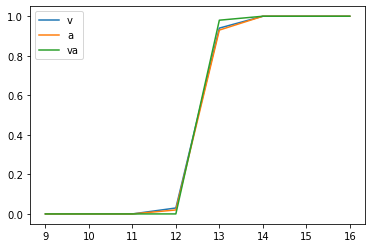


time cost = 437.98


In [5]:
import matplotlib.pyplot as plt
time1 = time.time()  
N_test = 100
dt_test = 0.5
r,P_matrix = test_batch(net1, dt_test, tau_m)
plt.plot(freqs,P_matrix[0],label=modalities[0])
plt.plot(freqs,P_matrix[1],label=modalities[1])
plt.plot(freqs,P_matrix[2],label=modalities[2])
plt.legend()
plt.show()
time2 = time.time()
print('\ntime cost = {:.2f}'.format(time2-time1))


In [31]:
import matplotlib.pyplot as plt
time1 = time.time()  
import random
num=8
matrix2 = np.zeros((num,3601,150))
for j in range(num):
    matrix2[j][0] = r[-1][:,j]
    for i in range(3600):
        matrix2[j][i+1] = r[i][:,j]
r_pca = matrix2.reshape(num*3601,Nrec)

def zeroMean(dataMat):      
    meanVal=np.mean(dataMat,axis=0)     #按列求均值，即求各个特征的均值
    newData=dataMat-meanVal
    return newData,meanVal
def percentage2n(eigVals,percentage):
    sortArray=np.sort(eigVals)   #升序
    sortArray=sortArray[-1::-1]  #逆转，即降序
    arraySum=sum(sortArray)
    tmpSum=0
    num=0
    for i in sortArray:
        tmpSum+=i
        num+=1
        if tmpSum>=arraySum*percentage:
            return num
def pca(dataMat,percentage=0.8):
    newData,meanVal=zeroMean(dataMat)
    covMat=np.cov(newData,rowvar=0)    #求协方差矩阵,return ndarray；若rowvar非0，一列代表一个样本，为0，一行代表一个样本
    eigVals,eigVects=np.linalg.eig(np.mat(covMat))#求特征值和特征向量,特征向量是按列放的，即一列代表一个特征向量
    eigVals = np.real(eigVals)
    n=percentage2n(eigVals,percentage) 
    eigValIndice=np.argsort(eigVals)            #对特征值从小到大排序
    n_eigValIndice=eigValIndice[-1:-(n+1):-1]   #最大的n个特征值的下标
    n_eigVect=eigVects[:,n_eigValIndice]        #最大的n个特征值对应的特征向量
    lowDDataMat=np.real(newData*n_eigVect)             #低维特征空间的数据
    reconMat=(lowDDataMat*n_eigVect.T)+meanVal  #重构数据
    return np.array(lowDDataMat),np.array(reconMat)
result,recons = pca(r_pca)
print(np.shape(result))


(28808, 4)


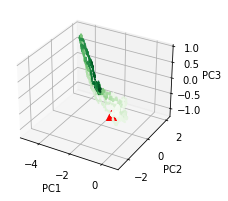

In [23]:
X_axis = []
Y_axis = []
Z_axis = []
for i in range(len(matrix2)):
    X_axis.append(result[3601*(i+1)-1,0]*1)
    Y_axis.append(result[3601*(i+1)-1,1]*1)
    Z_axis.append(result[3601*(i+1)-1,2]*1)
# result=[]
# for j in range(num):
#     xx1,xx2 = pca(matrix2[j])
#     result.append(xx1*1)
X_axis = np.array(X_axis)
Y_axis = np.array(Y_axis)
Z_axis = np.array(Z_axis)
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

from mpl_toolkits.mplot3d.axes3d import get_test_data

n = 1801/2
x = np.arange(0, n, step=.5)
y = x ** 2
cor=['Greens','Greys','Purples','Reds','Blues','Oranges']
# y 的值归一化到[0, 1]
# 因为 y 大到一定程度超过临界数值后颜色就会饱和不变(不使用循环colormap)。
norm = plt.Normalize(y.min(), y.max())
# matplotlib.colors.Normalize 对象，可以作为参数传入到绘图方法里
# 也可给其传入数值直接计算归一化的结果
norm_y = norm(y)
# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=plt.figaspect(0.2))
ax1 = plt.axes(projection='3d')
# fore = 660
# ax1.scatter3D(X_axis[0:4],Y_axis[0:4],Z_axis[0:4],s=10, c='blue',label='label = 0') 
# ax1.scatter3D(Y_axis[4:8],X_axis[4:8],Z_axis[4:8],s=10, c='red',label = 'label=1') 
# ax1.scatter3D(Y_axis[8:12],X_axis[8:12],Z_axis[8:12],s=10, c='purple',label = 'label=1') 
# # ax1.scatter3D(X_axis[12:16],Y_axis[12:16],Z_axis[12:16],s=10, c='green',label = 'label=1') 
# ax1.scatter3D(X_axis[16:24],Y_axis[16:24],Z_axis[16:24],s=10, c='black',label = 'label=1') 

# ax1.legend()
    # for i in [61,85]:
#     ax1.scatter3D(result[i*785:785*(i+1),0],result[i*785:785*(i+1),1],result[i*785:785*(i+1),2],s=1, c='red') 

    # ax = fig.add_subplot(1, 2, 2, projection='3d')
for i in range(4):
    ax1.scatter3D(result[(i)*3601:3601*(i+1),0][::2],result[(i)*3601:3601*(i+1),1][::2],result[(i)*3601:3601*(i+1),2][::2],s=0.5,c=norm_y, cmap=cor[int(i/4)]) 
# for i in range(4):
#     i=i+4
#     ax1.scatter3D(result[(i)*3601:3601*(i+1),0][::2],result[(i)*3601:3601*(i+1),1][::2],result[(i)*3601:3601*(i+1),2][::2],s=0.5,c=norm_y, cmap=cor[int(i/4)]) 
ax1.scatter3D(result[0,0],result[0,1],result[0,2],color='red',s=100,marker='^')
#===============
#  First subplot
#===============
# set up the axes for the first plot
ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")
ax1.set_zlabel("PC3")
# plt.savefig("cogni_va",dpi=1000,bbox_inches = 'tight')
plt.show()


In [133]:
r_pca[0,0]

0.0

# pixel by pixel

In [234]:
import numpy as np

def relu(arr):
    alpha=0.01
    output = np.where(arr > 0, arr, arr * 0.01)
    return output
def dlrelu(x):
    alpha=0.01
    dx = np.ones_like(x)
    dx[x < 0] = alpha
    return dx


#%% 定义函数
def f(x):
    return np.maximum(0,x)

def df(x):
    return np.where(x > 0, 1, 0)
'''
def gradient_clip(gra,bound):
    l2=(np.linalg.norm(gra,ord=2))
    if l2>=bound:
        return np.array((bound/l2)*gra)
    else:
        return np.array(gra)
'''
def grad_clip(gra,bound):
    l2=(np.linalg.norm(gra,ord=2))
    if l2>=bound:
        return np.array((bound/l2)*gra)
    else:
        return np.array(gra)

def decay(epoch,ddl,lr0,step):
    lr = (0.5**(epoch//step))*lr0
    lr[lr<=ddl] = ddl
    return lr
def sampling(m,p,v):
    import random
    m=np.array(m)
    p=np.array(p)
    v=np.array(v)
    b=np.ones((p.shape[0],p.shape[1]))
    ran=np.array(np.random.random((p.shape[0],p.shape[1]) ))
    for i in range(0,p.shape[0]):
        for j in range(0,p.shape[1]):
            if v[i][j]==0:
                b[i][j]=(turn_2_zero((ran[i][j]-p[i][j])))*m[i][j]
            else:
                b[i][j]=(turn_2_zero((ran[i][j]-p[i][j])))*(np.random.normal(m[i][j],np.sqrt(v[i][j])))
    return b
def turn1(mat):
    N=mat.shape[0]
    return(mat-np.diag(np.diag(mat))+np.eye(N))
def turn0(mat):
    N=mat.shape[0]
    return(mat-np.diag(np.diag(mat)))
def softmax(y):
    y = y - np.array(y.max(axis=0),ndmin=2)
    exp_y = np.exp(y) 
    sumofexp = np.array(exp_y.sum(axis=0),ndmin=2)
    softmax = exp_y/sumofexp
    return softmax
#%% 定义RNN类
class RNN:
    def __init__(self, n_in, n_rec, n_out,tau_m=10):
        self.n_in = n_in
        self.n_rec = n_rec
        self.n_out = n_out
        self.tau_m = tau_m
#         self.m_in =  np.array((np.random.normal(0,1,(n_rec,n_in))))
#         self.xi_in = np.zeros((n_rec,n_in))
#         self.pi_in = np.zeros((n_rec,n_in))
        
#         self.m_rec = np.load('RNN-SAS-pixel/1/RNN-SAS-m_rec_all.npy',allow_pickle=True)[-1]
#         self.xi_rec = np.load('RNN-SAS-pixel/1/RNN-SAS-sigma_rec_all.npy',allow_pickle=True)[-1]
#         self.pi_rec = np.load('RNN-SAS-pixel/1/RNN-SAS-pi_rec_all.npy',allow_pickle=True)[-1]
        
#         self.m_out =  np.array((np.random.normal(0,1,(n_out,n_rec)))/n_rec**0.5*n_in**0.5)
#         self.xi_out = 0.01*np.random.random((n_out,n_rec))
#         self.pi_out = np.zeros((n_out,n_rec))

        # Initialization of parameters: pi, m, xi
        # 用于刻画权重w的分布
        # 后一层在第一维度
        self.m_in =  np.load('RNN-SAS-pixel/1/RNN-SAS-m_in_all.npy',allow_pickle=True)[-1]
        self.xi_in = np.load('RNN-SAS-pixel/1/RNN-SAS-sigma_in_all.npy',allow_pickle=True)[-1]
        self.pi_in = np.load('RNN-SAS-pixel/1/RNN-SAS-pi_in_all.npy',allow_pickle=True)[-1]
        
        self.m_rec = np.load('RNN-SAS-pixel/1/RNN-SAS-m_rec_all.npy',allow_pickle=True)[-1]
        self.xi_rec = np.load('RNN-SAS-pixel/1/RNN-SAS-sigma_rec_all.npy',allow_pickle=True)[-1]
        self.pi_rec = np.load('RNN-SAS-pixel/1/RNN-SAS-pi_rec_all.npy',allow_pickle=True)[-1]
        
        self.m_out =  np.load('RNN-SAS-pixel/1/RNN-SAS-m_out_all.npy',allow_pickle=True)[-1]
        self.xi_out = np.load('RNN-SAS-pixel/1/RNN-SAS-sigma_out_all.npy',allow_pickle=True)[-1]
        self.pi_out = np.load('RNN-SAS-pixel/1/RNN-SAS-pi_out_all.npy',allow_pickle=True)[-1]


        #important intermediate variable
        #权重w的一阶矩和二阶矩
        self.mu_in = self.m_in*(1-self.pi_in)
        self.rho_in = (1-self.pi_in)*(self.xi_in + self.m_in**2)

        self.mu_rec = self.m_rec*(1-self.pi_rec)
        self.rho_rec = (1-self.pi_rec)*(self.xi_rec + self.m_rec**2)

        self.mu_out = self.m_out*(1-self.pi_out)
        self.rho_out = (1-self.pi_out)*(self.xi_out + self.m_out**2)
                


                   
    def update_moment(self):
        self.mu_in = self.m_in*(1-self.pi_in)
        self.rho_in = (1-self.pi_in)*(self.xi_in + self.m_in**2)

        self.mu_rec = self.m_rec*(1-self.pi_rec)
        self.rho_rec = (1-self.pi_rec)*(self.xi_rec + self.m_rec**2)

        self.mu_out = self.m_out*(1-self.pi_out)
        self.rho_out = (1-self.pi_out)*(self.xi_out + self.m_out**2)         
     
    # variance=0, grad->0    
    def variance_fix(self,delta):
        delt = delta*1
        delt[delta>0] = 1
        delt[delta<0] = 0
        return delt
    def sample_from_p(self,pi,m,xi):
        rand = np.random.random(np.shape(pi))
        w = np.random.normal(m,np.sqrt(xi))
        w_0 = self.variance_fix(rand-pi)
        return w*w_0
    def sample_w(self):
        self.w_in = self.sample_from_p(self.pi_in, self.m_in, self.xi_in)
        self.w_rec = self.sample_from_p(self.pi_rec, self.m_rec, self.xi_rec)
        self.w_out = self.sample_from_p(self.pi_out, self.m_out, self.xi_out)
    
    def sample_forward(self,x,y_,h0):
        # feedforward
        self.sample_w()
        t_max = np.shape(x)[0]  
        b_size = np.shape(x)[2]
        r = np.zeros((t_max+1, self.n_rec, b_size)) 
        h = np.zeros((t_max+1, self.n_rec, b_size))
        u = np.zeros((t_max, self.n_rec, b_size))  
        y = np.zeros((self.n_out,b_size)) 
        h[-1] = 1*h0
        r[-1] = f(h[-1])
        for tt in range(-1,t_max-1,1):
            self.sample_w()
            u[tt+1] = np.dot(self.w_rec, r[tt])+ np.dot(self.w_in, x[tt+1])
            h[tt+1] = h[tt] + (-h[tt] + u[tt+1])/self.tau_m
            r[tt+1]= f(h[tt+1])
        y=np.dot(self.w_out, r[t_max-1])
        
        accuracy = self.accuracy(y, y_)

        return r,accuracy,softmax(y)
    
    
    
    def accuracy(self,y,y_):
        targets = y_.argmax(axis=0)
        predicts = y.argmax(axis=0)
        return np.sum(targets==predicts)/np.size(targets)
    
    def run_bptt(self, x, y_, h0):
        t_max = np.shape(x)[0]  
        b_size = np.shape(x)[2]

        gm_in, gm_rec, gm_out = 0, 0, 0  # gradients of parameters m
        gxi_in, gxi_rec, gxi_out = 0, 0, 0  # gradients of parameters xi
        gpi_in, gpi_rec, gpi_out = 0, 0, 0  # gradients of parameters pi
    
        # input recurrent (feedforward plus recurrent)
        r = np.zeros((t_max+1, self.n_rec, b_size)) 
        h = np.zeros((t_max+1, self.n_rec, b_size))
        # 由于存在初始值h0，用h[-1]（即h[t_max]）存放h，r同理
        # h[t_max-1]仍标记演化的最后一时间步, r同理
    
        u = np.zeros((t_max, self.n_rec, b_size))  
        g = np.zeros((t_max, self.n_rec, b_size))
        delta = np.zeros((t_max, self.n_rec, b_size))
        epsi1=np.random.normal(0,1,(t_max,self.n_rec, b_size))
        epsi2=np.random.normal(0,1,(self.n_out, b_size))        
        

        # output 
        g_out = np.zeros((self.n_out,b_size))
        delta_out = np.zeros((self.n_out,b_size))         
        y = np.zeros((self.n_out,b_size))  # RNN output
        err = np.zeros((self.n_out,b_size))  # readout error     
    
        self.update_moment()
    
        # feedforward    
        h[-1] = 1*h0
        r[-1] = f(h[-1])
        for tt in range(-1,t_max-1,1):
            g[tt+1] = np.dot(self.mu_rec, r[tt])+ np.dot(self.m_in, x[tt+1])
            delta[tt+1] = np.sqrt(np.dot(self.rho_rec-self.mu_rec**2, r[tt]**2))         
            u[tt+1] = g[tt+1] + delta[tt+1] * epsi1[tt+1]
            h[tt+1] = h[tt] + (-h[tt] + u[tt+1])/self.tau_m
            r[tt+1] = f(h[tt+1])
        g_out = np.dot(self.mu_out, r[t_max-1])
        delta_out = np.sqrt(np.dot(self.rho_out-self.mu_out**2, r[t_max-1]**2))       
        y = g_out + delta_out * epsi2

    
    #softmax层
        softmax1=softmax(y)
        CE_k = (-y_*np.log(softmax1+pow(10,-5))).sum(axis=0)
        CE = np.sum(CE_k)/np.size(CE_k)
        accuracy = self.accuracy(y, y_)
        return CE,r,accuracy





    



def uni_permu(a,b,direction):
    if direction ==1:
        p = np.random.permutation(len(a.T))
        return np.array((a.T[p]).T), np.array((b.T[p]).T)
    if direction == 0:
        p = np.random.permutation(len(a))
        return np.array((a[p])), np.array((b[p]))

#%% 训练和测试函数
def data_shuffle(data1,label1):
    data = np.array(data1*1)
    label = np.array(label1*1)
    data,label = uni_permu(data,label,0)
    return data,label
    
bsize=30
def test(net, test_data, test_label,sampling=False):  
    #计算总数
    b_size = bsize 
    data = test_data
    targets = test_label
    h_test = 0.1*np.ones([n_rec,b_size])
    x_test = (data.T).reshape(784,1,b_size)      
    y_test = (targets).T
    r,accuracy,soft = net.sample_forward(x_test,y_test,h_test)
    return r,accuracy,soft
n_in=1
n_rec=100
n_out=10
net2 = RNN(n_in,n_rec,n_out)

In [235]:
mnist=(load.load_mnist(one_hot=True))
train_data = mnist[0][0][0:60000]
train_label = mnist[0][1][0:60000]
test_data = mnist[1][0][:10000]
test_label = mnist[1][1][:10000]

num_data=[]
num_label=[]
for k in [1,5,9]:
    temp=0
    for i in range(len(test_data)):
        i = i
        if np.argmax(test_label[i])==k:
            temp+=1
            num_data.append(test_data[i]*1)
            num_label.append(test_label[i]*1)
            if temp>=10:
                break
    print(temp)
num_data = np.array(num_data)
num_label=np.array(num_label)
# print(np.shape(num_data))
# print(np.shape(num_label))
# same_data = []
# same_label = []
# for i in range(num):
#     same_data.append(test_data[0]*1)
#     same_label.append(test_label[0]*1)
# same_data = np.array(same_data)
# same_label=np.array(same_label)    

10
10
10


In [260]:
data = [r_out,acc,soft]
np.save("1a5a9data",data,allow_pickle=True)

In [273]:
# r_out,acc,soft = test(net2, num_data, num_label,sampling=False)
r_out,acc,soft = np.load("formaldata/1a5a9data.npy",allow_pickle=True)
import random
num=bsize
matrix2 = np.zeros((num,785,n_rec))
for j in range(num):
    matrix2[j][0] = r_out[-1][:,j]
    for i in range(784):
        matrix2[j][i+1] = r_out[i][:,j]
# matrix3 = []
# soft2=[]
for i in range(10):
    if np.argmax(soft[:,i]) !=1:
        print (i)
for i in range(10):
    if np.argmax(soft[:,i+10]) !=5:
        print (i+10)
for i in range(10):
    if np.argmax(soft[:,i+20]) !=9:
        print (i+20)

        
#         matrix3.append(matrix2[i]*1)
#         soft2.append(soft[:,i]*1)
# # print("Before is ",len(matrix3))
# for i in range(num):
#     if np.argmax(soft[:,i]) ==5 and np.max(soft[:,i])>0.95:
#         matrix3.append(matrix2[i]*1)
#         soft2.append(soft[:,i]*1)
matrix3 = np.array(matrix2*1)
# soft2 = np.array(soft2)
r_pca = matrix3.reshape(len(matrix3)*785,n_rec)


def zeroMean(dataMat):      
    meanVal=np.mean(dataMat,axis=0)     #按列求均值，即求各个特征的均值
    newData=dataMat-meanVal
    return newData,meanVal
def percentage2n(eigVals,percentage):
    sortArray=np.sort(eigVals)   #升序
    sortArray=sortArray[-1::-1]  #逆转，即降序
    arraySum=sum(sortArray)
    tmpSum=0
    num=0
    for i in sortArray:
        tmpSum+=i
        num+=1
        if tmpSum>=arraySum*percentage:
            return num
def pca(dataMat,percentage=0.85):
    newData,meanVal=zeroMean(dataMat)
    covMat=np.cov(newData,rowvar=0)    #求协方差矩阵,return ndarray；若rowvar非0，一列代表一个样本，为0，一行代表一个样本
    eigVals,eigVects=np.linalg.eig(np.mat(covMat))#求特征值和特征向量,特征向量是按列放的，即一列代表一个特征向量
    eigVals = (eigVals)
    n=percentage2n(eigVals,percentage) 
    eigValIndice=np.argsort(eigVals)            #对特征值从小到大排序
    n_eigValIndice=eigValIndice[-1:-(n+1):-1]   #最大的n个特征值的下标
    n_eigVect=eigVects[:,n_eigValIndice]        #最大的n个特征值对应的特征向量
    lowDDataMat=np.real(newData*n_eigVect)             #低维特征空间的数据
    reconMat=np.real(lowDDataMat*n_eigVect.T)+meanVal  #重构数据
    return np.array(lowDDataMat),np.array(reconMat)
result,recons = pca(r_pca)
# X_axis = []
# Y_axis = []
# Z_axis = []
# for i in range(len(matrix3)):
#     X_axis.append(result[785*(i+1)-1,0]*1)
#     Y_axis.append(result[785*(i+1)-1,1]*1)
#     Z_axis.append(result[785*(i+1)-1,2]*1)
# # result=[]
# # for j in range(num):
# #     xx1,xx2 = pca(matrix2[j])
# #     result.append(xx1*1)
# X_axis = np.array(X_axis)
# Y_axis = np.array(Y_axis)
# Z_axis = np.array(Z_axis)
print(len(matrix3))
print(np.shape(result))
print(acc)

26
27
30
(23550, 3)
0.9333333333333333


In [237]:
from numpy import log as ln
def loss(x):
    return -np.sum(num_label[0]*ln(x))
for i in range(10):
    print((loss(soft[:,i])))

3.427974345450223e-05
6.857865648496674e-06
0.00012434403945538912
0.00039729986815869895
1.4927685084294377e-06
1.3181157709409858e-06
3.597363384676369e-05
1.6282619968004475e-06
4.163788817559055e-06
2.2954745164896436e-05


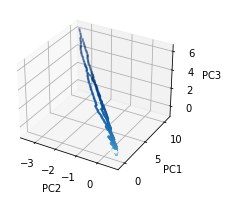

In [287]:

import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from matplotlib.pyplot import MultipleLocator
from mpl_toolkits.mplot3d.axes3d import get_test_data
cor=['Greens','Reds','Blues']
n = 785/2
x = np.arange(0, n, step=.5)
y = x ** 2
 
# y 的值归一化到[0, 1]
# 因为 y 大到一定程度超过临界数值后颜色就会饱和不变(不使用循环colormap)。
norm = plt.Normalize(y.min(), y.max())
# matplotlib.colors.Normalize 对象，可以作为参数传入到绘图方法里
# 也可给其传入数值直接计算归一化的结果
norm_y = norm(y)
# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=plt.figaspect(0.2))
ax1 = plt.axes(projection='3d')
# fore = 660
# ax1.scatter3D(Y_axis[0:fore],X_axis[0:fore],Z_axis[0:fore],s=1, c='blue',label='label = 0') 
# ax1.scatter3D(Y_axis[fore:],X_axis[fore:],Z_axis[fore:],s=1, c='red',label = 'label=1') 

# ax1.legend()
#     for i in [61,85]:
#     ax1.scatter3D(result[i*785:785*(i+1),0],result[i*785:785*(i+1),1],result[i*785:785*(i+1),2],s=1, c='red') 

    # ax = fig.add_subplot(1, 2, 2, projection='3d')
for i in [23,24,25]:
    ax1.scatter3D(result[(i)*785:785*(i+1),0],result[(i)*785:785*(i+1),1],result[(i)*785:785*(i+1),2], c=norm_y, cmap=cor[int(i/10)],s=2) 
# for i in [11,12,35,85]:
#     ax1.scatter3D(result[i*785:785*(i+1),0],result[i*785:785*(i+1),1],result[i*785:785*(i+1),2],s=1, c='red') 

ax1.set_xlabel("PC2")
ax1.set_ylabel("PC1")
ax1.set_zlabel("PC3")
# ax.set_xlabel("PC1")
# ax.set_ylabel("PC2")
# ax.set_zlabel("PC3")
# plt.savefig("formaldata/1a5a9allreverse",dpi=1000,bbox_inches = 'tight')
plt.show()


[2.91252688 1.54859255 0.03940542]
r-squared value of 0.2301400515850216
[ 0.67356715 -0.11767014  0.74681291]
r-squared value of 0.25514969196645887


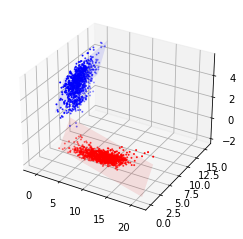

In [69]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
def EquationFunc(x,w):
    return w[0]*1+w[1]*x[0]+w[2]*x[1]

def plane_fit(x,y,z):
    X = []
    Y = []
    for i in range(len(x)): # contains 3 columns: x1, x2, and y
        X.append([1, float(x[i]), float(y[i])]) # here X[i][0] represents x0 = 1
        Y.append(float(z[i]))
    X = np.array(X)
    Y = np.array(Y)
    w = np.linalg.solve(X.T.dot(X), X.T.dot(Y))
    print(w)
    Yhat = X.dot(w)
    d1 = Y - Yhat
    d2 = Y - Y.mean()
    r2 = 1 - d1.dot(d1) / d2.dot(d2)
    print("r-squared value of", r2)
    x1_range = np.linspace(min(X[:,1]),max(X[:,1]),2)
    x2_range = np.linspace(min(X[:,2]),max(X[:,2]),2)
    X1, X2 = np.meshgrid(x1_range, x2_range) # intentional ordering: X2, *then* X1
    Z = EquationFunc(np.array([X1,X2]),w)
    return X1,X2,Z

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
xx,yy,zz = plane_fit(X_axis[0:fore],Y_axis[0:fore],Z_axis[0:fore])
xx2,yy2,zz2 = plane_fit(X_axis[fore:],Y_axis[fore:],Z_axis[fore:])
ax.scatter3D(X_axis[0:fore],Y_axis[0:fore],Z_axis[0:fore],s=1, c='blue') 
ax.scatter3D(X_axis[fore:],Y_axis[fore:],Z_axis[fore:],s=1, c='red') 
ax.plot_surface(xx,yy, zz, color='b', alpha=0.1) # plane of best fit
ax.plot_surface(xx2,yy2, zz2, color='r', alpha=0.1) # plane of best fit


plt.show()